## Import Statements

In [705]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error as mae, max_error
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from random import shuffle
from tobit import *

## Read files into dataframe

In [706]:
path = 'NonCropShare/'

datac = pd.io.stata.read_stata(path+'joinedDataCambodia.dta')
datav = pd.io.stata.read_stata(path+'joinedDataVietnam.dta')

## Explore data

In [707]:
print('Unique to Cambodia:')
print(set(datac.columns) - set(datav.columns))
print()
print('Unique to Vietnam:')
print(set(datav.columns) - set(datac.columns))

Unique to Cambodia:
{'theta_1', 'theta_2', 'p1'}

Unique to Vietnam:
{'theta', 'z9_n'}


In [708]:
print('Common to both:')
set(datav.columns).intersection(set(datac.columns))

Common to both:


{'AveRelationship',
 'Game',
 'GameOrder',
 'Player1HHID',
 'Player1_Score',
 'Player1_Shannon',
 'Player1_Time',
 'Player2HHID',
 'Player2_Score',
 'Player2_Shannon',
 'Player2_Time',
 'Player3HHID',
 'Player3_Score',
 'Player3_Shannon',
 'Player3_Time',
 'Player4HHID',
 'Player4_Score',
 'Player4_Shannon',
 'Player4_Time',
 'Round',
 'Session',
 'avePlayerShannon',
 'canceledNCH',
 'choiceCell1',
 'choiceCell10',
 'choiceCell11',
 'choiceCell12',
 'choiceCell13',
 'choiceCell14',
 'choiceCell15',
 'choiceCell16',
 'choiceCell17',
 'choiceCell18',
 'choiceCell19',
 'choiceCell2',
 'choiceCell20',
 'choiceCell21',
 'choiceCell22',
 'choiceCell23',
 'choiceCell24',
 'choiceCell25',
 'choiceCell26',
 'choiceCell27',
 'choiceCell28',
 'choiceCell29',
 'choiceCell3',
 'choiceCell30',
 'choiceCell31',
 'choiceCell32',
 'choiceCell33',
 'choiceCell34',
 'choiceCell35',
 'choiceCell36',
 'choiceCell4',
 'choiceCell5',
 'choiceCell6',
 'choiceCell7',
 'choiceCell8',
 'choiceCell9',
 'country',

In [709]:
# Drop the uncommon attributes and original identifier z1 from both dataframes
datac.drop(columns=['p1', 'theta_1', 'theta_2', 'z1'], inplace=True)
datav.drop(columns=['theta', 'z9_n', 'z1'], inplace=True)

In [710]:
len(datac.columns) == len(datav.columns)

True

## Cambodia Table:

### 117 sessions x {(4 games/session x 8 rounds/game) + (1 practice-game/session x  3 rounds/practice-game)}

### = 4095 rounds

## Vietnam Table:

### 128 sessions x {(4 games/session x 8 rounds/game) + (1 practice-game/session x  3 rounds/practice-game)}

### = 4480 rounds

In [711]:
print(len(datac))
print(len(datav))

4095
4480


## Cooperative Production

In [712]:
# Calculate landscape production
datac['landscapeProduction'] = datac['gameScores'] - datac['sumSubsidies']
datav['landscapeProduction'] = datav['gameScores'] - datav['sumSubsidies']

# Calculate cooperative outcome
datac['cooperativeOutcome'] = (36 - datac['numHS']) / 36
datav['cooperativeOutcome'] = (36 - datav['numHS']) / 36

# Calculate cooperative production
datac['cooperativeProduction'] = (datac['landscapeProduction'] * datac['cooperativeOutcome']) / 360
datav['cooperativeProduction'] = (datav['landscapeProduction'] * datav['cooperativeOutcome']) / 360

In [713]:
datac['cooperativeProduction'].describe()

count    4095.000000
mean        0.408861
std         0.228659
min         0.000000
25%         0.246952
50%         0.416358
75%         0.557948
max         0.986111
Name: cooperativeProduction, dtype: float64

In [714]:
datav['cooperativeProduction'].describe()

count    4480.000000
mean        0.683819
std         0.248059
min         0.000000
25%         0.531636
50%         0.731944
75%         0.894444
max         1.033333
Name: cooperativeProduction, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


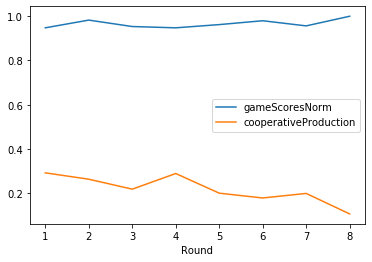

In [715]:
# Check if gameScores are proprotional to cooperativeProduction or not

gamedf = datac[(datac['Game']=='G4') & (datac['Session']==211)]
gamedf['gameScoresNorm'] = gamedf['gameScores'] / max(gamedf['gameScores'])
gamedf[['Round', 'gameScoresNorm', 'cooperativeProduction']].set_index('Round').sort_index().plot(kind='line')

## Missing value imputation

In [716]:
# Players' attributes lists, all other game related attributes have no missing valuess

categorical_var = ['_commune', '_district', '_drought', '_flood', '_floodLandslide', '_homeGardenSafe', '_instructedPest', 
                   '_pestHazard', '_selfGender', '_selfLeader', '_selfLit', '_storms', '_useChemFert', '_useImprovedSeed', 
                  '_useOrgFert', '_usePesticide', '_village']

numerical_var = ['_alpha', '_cropSale', '_femaleLabor', '_fracSold_area', '_fracSold_harvest', '_lambda', '_landHHeadDecides', 
              '_landHHeadWorked', '_landOwned', '_landWorked', '_maleLabor', '_numPlots', '_pestCost', '_selfAge', 
              '_selfEd', '_selfExp', '_sigma', '_weedingCost', '_weedingLabor']

categorical_var_extended = ['p1'+s for s in categorical_var] + ['p2'+s for s in categorical_var] + ['p3'+s for s in categorical_var] + ['p4'+s for s in categorical_var]
numerical_var_extended = ['p1'+s for s in numerical_var] + ['p2'+s for s in numerical_var] + ['p3'+s for s in numerical_var] + ['p4'+s for s in numerical_var]

In [717]:
# Cambodia dataset
nan_columns = set(datac.columns[datac.isna().any()]) # attributes that have missing values
categorical_nan_cols = nan_columns.intersection(categorical_var_extended) # categorical attributes that have missing values
numerical_nan_cols = nan_columns.intersection(numerical_var_extended) # numerical attributes that have missing values

# look at the categorical attribute for replacement method selection
for attrib in categorical_nan_cols:
    print(attrib, datac[attrib].unique())

p3_useChemFert [ 1.  0. nan]
p4_storms [ 0. nan  1.]
p3_pestHazard [ 1.  2. nan]
p3_instructedPest [ 2.  1. nan]
p4_flood [ 0.  1. nan]
p4_drought [ 1.  0. nan]
p4_useImprovedSeed [ 1.  0. nan]
p3_useOrgFert [ 1.  0. nan]
p4_usePesticide [ 0.  1. nan]
p4_useChemFert [ 1.  0. nan]
p4_useOrgFert [ 1.  0. nan]
p4_floodLandslide [ 0. nan]
p3_homeGardenSafe [ 0.  1. nan]
p3_useImprovedSeed [ 1.  0. nan]
p3_storms [ 0.  1. nan]
p3_floodLandslide [ 0. nan]
p3_usePesticide [ 0.  1. nan]
p3_drought [ 1.  0. nan]
p3_flood [ 0.  1. nan]
p4_homeGardenSafe [ 0.  1. nan]


In [718]:
# Replace missing values in categorical attributes by minimum and in numerical attributes by 0
datac[list(categorical_nan_cols)] = datac[list(categorical_nan_cols)].fillna(0)
datac[list({'p3_pestHazard', 'p3_instructedPest'})] = datac[list({'p3_pestHazard', 'p3_instructedPest'})].fillna(1)
datac[list(numerical_nan_cols)] = datac[list(numerical_nan_cols)].fillna(0)

In [719]:
# Check if there are any missing values
datac.isna().any().any()

False

In [720]:
# Vietnam dataset
nan_columns = set(datav.columns[datav.isna().any()]) # attributes that have missing values
categorical_nan_cols = nan_columns.intersection(categorical_var_extended) # categorical attributes that have missing values
numerical_nan_cols = nan_columns.intersection(numerical_var_extended) # numerical attributes that have missing values

# look at the categorical attribute for replacement method selection
for attrib in categorical_nan_cols:
    print(attrib, datac[attrib].unique())

p2_instructedPest [1. 2.]
p3_selfGender [1. 2.]
p2_useOrgFert [1. 0.]
p3_useChemFert [1. 0.]
p3_selfLit [2. 1.]
p2_selfLeader [1. 2.]
p2_useImprovedSeed [1. 0.]
p2_pestHazard [1. 2.]
p2_useChemFert [1. 0.]
p4_storms [0. 1.]
p3_district [7. 8. 6. 2. 3. 5. 1. 4.]
p4_commune [701. 801. 601. 702. 201. 301. 503. 802. 803. 302. 502. 501. 102. 401.
 101.]
p4_selfLeader [2. 1.]
p3_pestHazard [1. 2. 0.]
p3_instructedPest [2. 1. 0.]
p4_instructedPest [2. 1.]
p3_village [70101. 80101. 60101. 70201. 20101. 30101. 50301. 80201. 80301. 30201.
 30102. 50201. 50101. 10201. 40101. 10101.]
p2_floodLandslide [0. 1.]
p4_flood [0. 1.]
p4_drought [1. 0.]
p2_village [70101. 80101. 60101. 70201. 20101. 30101. 50301. 80201. 80301. 30102.
 50201. 50101. 10201. 40101. 30201. 10101.]
p4_useImprovedSeed [1. 0.]
p3_useOrgFert [1. 0.]
p4_selfGender [2. 1.]
p4_selfLit [1. 2.]
p2_flood [0. 1.]
p4_usePesticide [0. 1.]
p2_storms [0. 1.]
p4_useChemFert [1. 0.]
p4_useOrgFert [1. 0.]
p4_floodLandslide [0.]
p2_commune [701.

In [721]:
# separate location columns, gender columns and remaining columns
loc_cols = ['p3_district', 'p4_commune', 'p3_village', 'p2_village', 'p2_commune', 'p1_village', 'p2_district', 'p4_village', 'p4_district', 'p3_commune']
gender_cols = ['p2_selfGender', 'p3_selfGender', 'p4_selfGender']
rem_cols = list(categorical_nan_cols - set(loc_cols) - set(gender_cols))

In [722]:
# replace missing location with -1, missing gender with the most frequently occurring gender (1)
# replace remaining missing categorical attributes with minimum and missing numerical attributes with 0
datav[loc_cols] = datav[loc_cols].fillna(-1)
datav[gender_cols] = datav[gender_cols].fillna(1)
datav[rem_cols] = datav[rem_cols].fillna(datav[rem_cols].min())
datav[list(numerical_nan_cols)] = datav[list(numerical_nan_cols)].fillna(0)

In [723]:
# Check if there are any missing values
datav.isna().any().any()

False

## Analysis 1: Predict CP using last round (#8) of each game

In [724]:
# One hot encode the treatment variable 'Game'
datac = pd.concat([datac, pd.get_dummies(datac['Game'])], axis = 1)
datav = pd.concat([datav, pd.get_dummies(datav['Game'])], axis = 1)

In [725]:
# Drop all practice game records and records of rounds other than round #8
datac.drop(datac[datac['Round']<8].index, inplace=True)
datac.drop(datac[datac['Game']=='GP'].index, inplace=True)
datav.drop(datav[datav['Round']<8].index, inplace=True)
datav.drop(datav[datav['Game']=='GP'].index, inplace=True)

In [726]:
# Drop tapCell{x}, choiceCell{x}, Game, GameOrder, Session, Round, hhid and GP
# Drop player identifier (Player{x}HHID), leakage/ irrelevant variables (Player{x}_Score, Player{x}_Shannon, Player{x}_Time)

datac.drop(columns=['Game', 'GameOrder', 'Session', 'Round', 'hhid', 'GP'], inplace=True)
datac.drop(columns=['tapCell'+str(x) for x in range(1,37)], inplace=True)
datac.drop(columns=['choiceCell'+str(x) for x in range(1,37)], inplace=True)
datac.drop(columns=['Player'+str(x)+'HHID' for x in range(1,5)], inplace=True)
datac.drop(columns=['Player'+str(x)+'_Score' for x in range(1,5)], inplace=True)
datac.drop(columns=['Player'+str(x)+'_Shannon' for x in range(1,5)], inplace=True)
datac.drop(columns=['Player'+str(x)+'_Time' for x in range(1,5)], inplace=True)

datav.drop(columns=['Game', 'GameOrder', 'Session', 'Round', 'hhid', 'GP'], inplace=True)
datav.drop(columns=['tapCell'+str(x) for x in range(1,37)], inplace=True)
datav.drop(columns=['choiceCell'+str(x) for x in range(1,37)], inplace=True)
datav.drop(columns=['Player'+str(x)+'HHID' for x in range(1,5)], inplace=True)
datav.drop(columns=['Player'+str(x)+'_Score' for x in range(1,5)], inplace=True)
datav.drop(columns=['Player'+str(x)+'_Shannon' for x in range(1,5)], inplace=True)
datav.drop(columns=['Player'+str(x)+'_Time' for x in range(1,5)], inplace=True)

In [727]:
# Selecting treatment and subsidy related attributes and dropping the rest

# Variables to be kept: 'nchYield', 'avePlayerShannon', 'AveRelationship',
# 'totalArea', 'totalHarvest', 'cooperativeProduction' (which is to be predicted later)

# Drop leakage variables: 'gameScores', 'sumSubsidies', 'landscapeProduction', 'cooperativeOutcome',
# 'numNCH', 'numHS', 'numLS', 'totalTaps', 'nchBenefits', 'nchBenefitsSelf', 'canceledNCH', 'pestBenefits', 'gameShannon'
# Drop 'country' unless mixing data

drop_list = ['gameScores', 'sumSubsidies', 'landscapeProduction', 'cooperativeOutcome', 'numNCH', 'numHS', 'numLS',
             'totalTaps', 'nchBenefits', 'nchBenefitsSelf', 'canceledNCH', 'pestBenefits', 'country', 'gameShannon']

datac.drop(columns=drop_list, inplace=True)
datav.drop(columns=drop_list, inplace=True)

In [728]:
# Add country column
datav['country'] = 0
datac['country'] = 1

In [729]:
# Concatenate the two dataframes
data = pd.concat([datac, datav], axis=0)

In [730]:
len(data)

980

In [731]:
# Players' attributes/ characteristics lists

categorical_var = ['_commune', '_district', '_drought', '_flood', '_floodLandslide', '_homeGardenSafe', '_instructedPest', 
                   '_pestHazard', '_selfGender', '_selfLeader', '_selfLit', '_storms', '_useChemFert', '_useImprovedSeed', 
                  '_useOrgFert', '_usePesticide', '_village']

numerical_var = ['_alpha', '_cropSale', '_femaleLabor', '_fracSold_area', '_fracSold_harvest', '_lambda', '_landHHeadDecides', 
              '_landHHeadWorked', '_landOwned', '_landWorked', '_maleLabor', '_numPlots', '_pestCost', '_selfAge', 
              '_selfEd', '_selfExp', '_sigma', '_weedingCost', '_weedingLabor']

In [732]:
# Convert categorical_var from float to int (to remove .0)
for var in categorical_var:
    data['p1'+var] = data['p1'+var].astype(int)
    data['p2'+var] = data['p2'+var].astype(int)
    data['p3'+var] = data['p3'+var].astype(int)
    data['p4'+var] = data['p4'+var].astype(int)

In [733]:
# Create count vector features or dummy variables for the nominal categorical variables (gender, location or otherwise)
# to calculate the fraction of players belonging to each new category (divide by 4 for fraction)

for chrct in categorical_var:
    value_set = []
    value_set += list(data['p1'+chrct].unique())
    value_set += list(data['p2'+chrct].unique())
    value_set += list(data['p3'+chrct].unique())
    value_set += list(data['p4'+chrct].unique())
    value_set = list(set(value_set))
    value_set
    for val in value_set:
        data['p'+chrct+'_'+str(val)] = data[['p1'+chrct, 'p2'+chrct, 'p3'+chrct, 'p4'+chrct]][data[['p1'+chrct, 'p2'+chrct, 'p3'+chrct, 'p4'+chrct]]==val].count(axis=1) / 4
    data.drop(columns=['p1'+chrct, 'p2'+chrct, 'p3'+chrct, 'p4'+chrct], inplace=True)

In [734]:
# Calculate mean and variance of the numerical attributes (characteristics) across 4 players, drop the single player information
for chrct in numerical_var:
    data['p'+chrct+'_mean'] = data[['p1'+chrct, 'p2'+chrct, 'p3'+chrct, 'p4'+chrct]].mean(axis=1)
    data['p'+chrct+'_var'] = data[['p1'+chrct, 'p2'+chrct, 'p3'+chrct, 'p4'+chrct]].var(axis=1)
    data.drop(columns=['p1'+chrct, 'p2'+chrct, 'p3'+chrct, 'p4'+chrct], inplace=True)

### Train-test split: Sorted Stratification

In [735]:
data.sort_values(by='cooperativeProduction', inplace=True)
data.reset_index(inplace=True)

In [737]:
#train, test = train_test_split(data, test_size=0.2, stratify=y_binned)
train = data.iloc[np.setdiff1d(np.arange(0,980), np.arange(4,980,5))]
test = data.iloc[np.arange(4,980,5)]
train.drop(columns='index', inplace=True)
test.drop(columns='index', inplace=True)
train = train.sample(frac=1)
test = test.sample(frac=1)

### Linear Regression

0.6713070978970506
0.5978552562789146
0.1312188027156754
0.14744055246519905
0.572998046875
0.516357421875


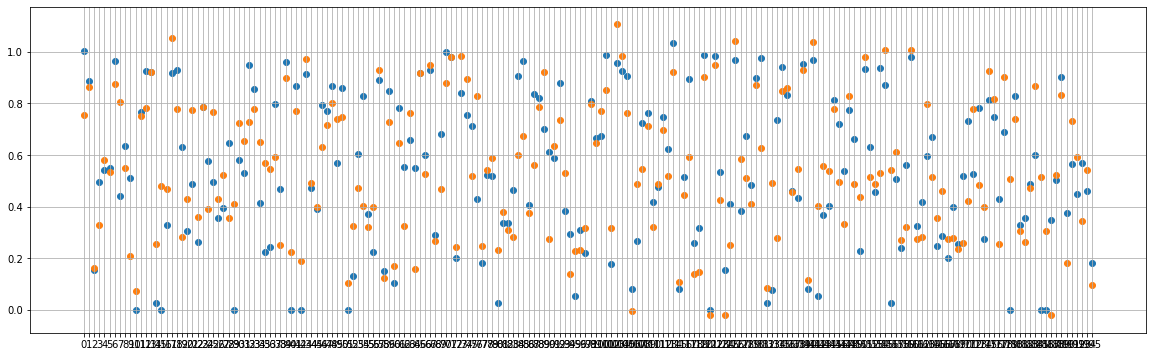

In [740]:
#r2_train_list, r2_test_list, mae_train_list, mae_test_list, maxerr_train_list, maxerr_test_list = [], [], [], [], [], []

logreg = LinearRegression(normalize=True).fit(train.drop(columns='cooperativeProduction'), train['cooperativeProduction'])

print(r2_score(train['cooperativeProduction'], logreg.predict(train.drop(columns='cooperativeProduction'))))
print(r2_score(test['cooperativeProduction'], logreg.predict(test.drop(columns='cooperativeProduction'))))

print(mae(train['cooperativeProduction'], logreg.predict(train.drop(columns='cooperativeProduction'))))
print(mae(test['cooperativeProduction'], logreg.predict(test.drop(columns='cooperativeProduction'))))

print(max_error(train['cooperativeProduction'], logreg.predict(train.drop(columns='cooperativeProduction'))))
print(max_error(test['cooperativeProduction'], logreg.predict(test.drop(columns='cooperativeProduction'))))

fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(list(range(len(test))), test['cooperativeProduction'])
ax1.scatter(list(range(len(test))), logreg.predict(test.drop(columns='cooperativeProduction')))
plt.xticks(list(range(len(test))))
ax1.grid()

### Polynomial Regression

In [741]:
poly = PolynomialFeatures(degree=2, interaction_only=False)
X_train = poly.fit_transform(train.drop(columns='cooperativeProduction'))
X_test = poly.transform(test.drop(columns='cooperativeProduction'))

logreg = LinearRegression(normalize=True).fit(X_train, train['cooperativeProduction'])

print(r2_score(train['cooperativeProduction'], logreg.predict(X_train)))
print(r2_score(test['cooperativeProduction'], logreg.predict(X_test)))

print(mae(train['cooperativeProduction'], logreg.predict(X_train)))
print(mae(test['cooperativeProduction'], logreg.predict(X_test)))

print(max_error(train['cooperativeProduction'], logreg.predict(X_train)))
print(max_error(test['cooperativeProduction'], logreg.predict(X_test)))

0.9878506422068862
-3.3375897319997115e+21
0.02418966257292848
3038446401.309989
0.19945746527777775
145287655415.9015


### Tobit Model

In [742]:
tr = TobitModel()
result = tr.fit(train.drop(columns='cooperativeProduction'), train['cooperativeProduction'], cens=pd.Series(), verbose=False)
print(tr.score(test.drop(columns='cooperativeProduction'), test['cooperativeProduction'], scoring_function=r2_score))
print(tr.score(test.drop(columns='cooperativeProduction'), test['cooperativeProduction'], scoring_function=mean_absolute_error))

0.5319878550154649
0.16454675759332263


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\apurv\tobit.py:16: UserWarning: No censored observations; use regression methods for uncensored data
  warnings.warn("No censored observations; use regression methods for uncensored data")


### Decision Tree

In [743]:
param_grid = {'min_samples_split': np.arange(2, 10), 'min_samples_leaf': np.arange(1,10), 'criterion': ['mse', 'friedman_mse', 'mae']}
dtreg = GridSearchCV(DecisionTreeRegressor(), param_grid)
dtreg.fit(train.drop(columns='cooperativeProduction'), train['cooperativeProduction'])
print(r2_score(train['cooperativeProduction'], dtreg.predict(train.drop(columns='cooperativeProduction'))))
print(r2_score(test['cooperativeProduction'], dtreg.predict(test.drop(columns='cooperativeProduction'))))
print(mae(train['cooperativeProduction'], dtreg.predict(train.drop(columns='cooperativeProduction'))))
print(mae(test['cooperativeProduction'], dtreg.predict(test.drop(columns='cooperativeProduction'))))

0.9800018306838558
0.6384727061384989
0.023544596272150838
0.12205071071638532


In [744]:
# Get the decision tree parameters
dtreg.best_params_

{'criterion': 'friedman_mse', 'min_samples_leaf': 1, 'min_samples_split': 4}

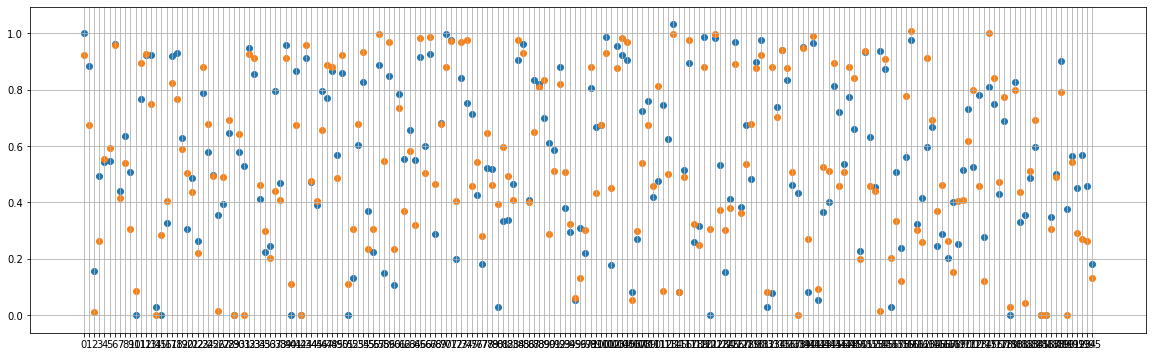

In [745]:
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(list(range(len(test))), test['cooperativeProduction'])
ax1.scatter(list(range(len(test))), dtreg.predict(test.drop(columns='cooperativeProduction')))
plt.xticks(list(range(len(test))))
ax1.grid()

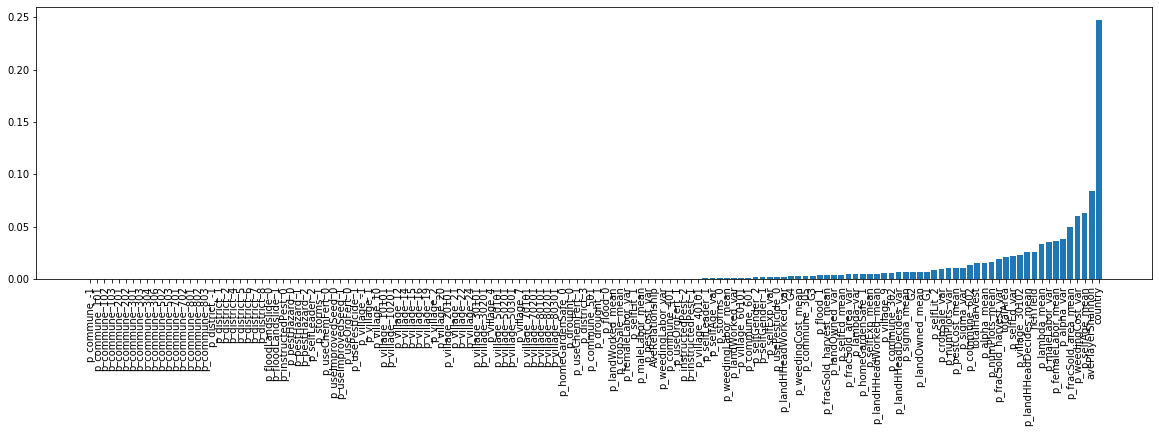

In [747]:
# Plot feature importances
plt.figure(figsize=(20,5))
feature_list = train.drop(columns='cooperativeProduction').columns
feature_imp = dtreg.best_estimator_.feature_importances_
feature_imp, feature_list = zip(*sorted(zip(feature_imp, feature_list)))
plt.bar(feature_list, feature_imp)
plt.xticks(rotation=90)
plt.show()

In [762]:
# Get R2 score difference and MAE difference for each feature
r2_all = 0.6384727061384989
mae_all = 0.12205071071638532
r2_diff, mae_diff =[], []
for feature in feature_list[-10:]:
    print(feature)
    param_grid = {'min_samples_split': np.arange(2, 10), 'min_samples_leaf': np.arange(1,10), 'criterion': ['mse', 'friedman_mse', 'mae']}
    dtreg = GridSearchCV(DecisionTreeRegressor(), param_grid)
    dtreg.fit(train.drop(columns=['cooperativeProduction', feature]), train['cooperativeProduction'])
    #print(r2_score(train['cooperativeProduction'], dtreg.predict(train.drop(columns=['cooperativeProduction', feature]))))
    r2_diff.append(r2_all - r2_score(test['cooperativeProduction'], dtreg.predict(test.drop(columns=['cooperativeProduction', feature]))))
    #print(mae(train['cooperativeProduction'], dtreg.predict(train.drop(columns=['cooperativeProduction', feature]))))
    mae_diff.append(mae_all - mae(test['cooperativeProduction'], dtreg.predict(test.drop(columns=['cooperativeProduction', feature]))))

nchYield
p_lambda_mean
p_maleLabor_var
p_femaleLabor_mean
p_alpha_var
p_fracSold_area_mean
p_weedingCost_var
p_selfAge_mean
avePlayerShannon
country


In [766]:
print(*zip(feature_list[-10:], mae_diff))
print()
print(*zip(feature_list[-10:], r2_diff))

('nchYield', 0.00675810447635844) ('p_lambda_mean', 0.0023517285000419913) ('p_maleLabor_var', 0.0011710282415769435) ('p_femaleLabor_mean', 0.01354302859812355) ('p_alpha_var', 0.0024600812547241058) ('p_fracSold_area_mean', 0.006499721802301184) ('p_weedingCost_var', 0.0031293960485428707) ('p_selfAge_mean', 0.005155394223385998) ('avePlayerShannon', 0.007075276098093566) ('country', 0.006337173455140427)

('nchYield', -0.04258970154485375) ('p_lambda_mean', -0.031115649679655633) ('p_maleLabor_var', -0.00015476662777413885) ('p_femaleLabor_mean', -0.06561636244073199) ('p_alpha_var', -0.019758946294303303) ('p_fracSold_area_mean', -0.021733130780802856) ('p_weedingCost_var', -0.011684282604181528) ('p_selfAge_mean', -0.01748209390392541) ('avePlayerShannon', -0.05795519558266382) ('country', -0.05609451834074619)


## Analysis 2: Predict CP using last 3 rounds (#6, #7, #8 - averaged) of each game

In [618]:
# Drop all practice game records and records of rounds other than rounds #6, #7 and #8
datac.drop(datac[datac['Round']<6].index, inplace=True)
datac.drop(datac[datac['Game']=='GP'].index, inplace=True)
datav.drop(datav[datav['Round']<6].index, inplace=True)
datav.drop(datav[datav['Game']=='GP'].index, inplace=True)

# Calculate average of last 3 rows:
meanCPtable = datac[['Session', 'Game', 'cooperativeProduction']].groupby(['Session', 'Game']).mean().reset_index()

# Using above table, replace the CP with its mean
for session in datac['Session'].unique():
    for game in datac['Game'].unique():
        datac.loc[(datac.Session==session) & (datac.Game==game), 'cooperativeProduction'] = \
        meanCPtable.loc[(meanCPtable.Session==session) & (meanCPtable.Game==game), 'cooperativeProduction'].iloc[0]
        
# Drop records of rounds other than #8
datac.drop(datac[datac['Round']<8].index, inplace=True)